#### iLQR for point mass example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import inv
from IPython.display import clear_output
import time
from ocp import *
from costs import *
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=True)

#### Create point mass system with dimension 2 (double integrator)

In [2]:
dt = 0.05
T = 100
Dx, Du = 4, 2
A = np.eye(Dx)
A[:2,2:] = np.eye(2)*dt
B = np.zeros((Dx, Du))
B[2:, :] = np.eye(Du)

sys = LinearSystem(A, B)

#### Set initial state and control trajectory

In [87]:
x0 = np.zeros(Dx)
x0[3] = 0
sys.set_init_state(x0)

#set initial control output to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [88]:
Q = np.eye(sys.Dx)*0.
#Q[0:2,0:2] *= 0.0
Qf = np.eye(sys.Dx)*0
#Qf[0:2,0:2] *= 0.0
R = np.eye(sys.Du)*.001
mu = 1e-6

#### Set reference target

In [89]:
x_ref = np.array([2, 2, 0,0])

#### Set obstacle

In [101]:
p_obs1 = np.array([1.1,1.1])
Sigma_obs1 = np.diag([0.7, 0.7])
w_obs1 = 10
r_obs1 = 2

### iLQR using cost model

#### Define the cost

In [102]:
#The costs consist of: a) state tracking (Q), b) control regularization (R)
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T
costs = []

for i in range(T):
    runningStateCost = CostModelQuadratic(sys, Q, x_ref = x_ref)
    runningControlCost = CostModelQuadratic(sys, None, R)
    #runningObstacleCost = CostModelCollisionEllipsoid(sys, p_obs1, Sigma_obs1, w_obs1)
    activation = ActivationCollision(nr=2, threshold = r_obs1)
    runningObstacleCost = CostModelCollisionCircle(sys, activation, p_obs1, Sigma_obs1, w_obs1)
    
    runningCost = CostModelSum(sys, [runningStateCost, runningControlCost, runningObstacleCost])
    costs += [runningCost]

terminalStateCost = CostModelQuadratic(sys,Qf, x_ref = x_ref)
terminalControlCost = CostModelQuadratic(sys, None,R)
#terminalObstacleCost = CostModelCollisionEllipsoid(sys, p_obs1, Sigma_obs1, w_obs1)
activation = ActivationCollision(nr=2, threshold = r_obs1)
terminalObstacleCost = CostModelCollisionCircle(sys, activation, p_obs1, Sigma_obs1, w_obs1)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost, terminalObstacleCost])

costs += [terminalCost]

#### Construct ILQR

In [103]:
ilqr_cost = ILQR(sys)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us)

#### Solve and Plot

#### Solve

In [104]:
ilqr_cost.k[0]

array([0., 0.])

In [105]:
ilqr_cost.Lx[0]

array([0., 0., 0., 0.])

In [106]:
ilqr_cost.Fu[0]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [107]:
ilqr_cost.Qu[0]

array([0., 0.])

In [108]:
ilqr_cost.Quu[0]

array([[0., 0.],
       [0., 0.]])

In [109]:
ilqr_cost.Vxx[0]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [110]:
n_iter = 10
ilqr_cost.solve(n_iter, method='batch')
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us

clear_output()

In [111]:
idx = -1

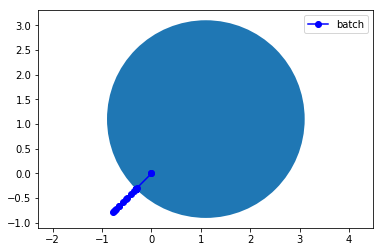

In [112]:
fig, ax = plt.subplots()
ax.plot(xs_batch[:idx,0], xs_batch[:idx,1], 'b-o', label='batch')
ax.plot(p_obs1[0], p_obs1[1], 'o', markersize=10)
c1 = plt.Circle(p_obs1, radius=r_obs1)
ax.add_patch(c1)
ax.legend()
plt.axis('equal')
plt.show()

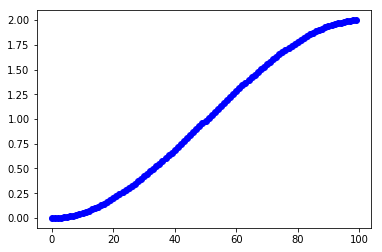

In [70]:
plt.plot(xs_batch[:idx,0],'b-o', label='batch')

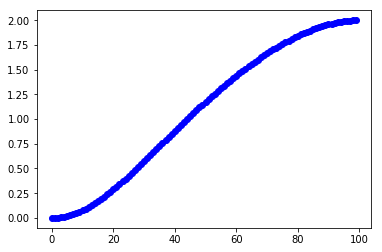

In [24]:
plt.plot(xs_batch[:idx,1],'b-o', label='batch')

#### Print obstacle costs

In [162]:
ilqr_cost.costs[0].Lxx

array([[-0.5556,  0.    ,  0.    ,  0.    ],
       [ 0.    , -0.5556,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ]])

In [161]:
for i in range(T+1):
    cost_obs = ilqr_cost.costs[i].costs[-1]
    print(i, cost_obs.Lx)

(0, array([0.3333, 0.2778, 0.    , 0.    ]))
(1, array([0.3333, 0.2778, 0.    , 0.    ]))
(2, array([0.3275, 0.2729, 0.    , 0.    ]))
(3, array([0.3104, 0.2587, 0.    , 0.    ]))
(4, array([0.2798, 0.2332, 0.    , 0.    ]))
(5, array([0.2362, 0.1968, 0.    , 0.    ]))
(6, array([0.1825, 0.1521, 0.    , 0.    ]))
(7, array([0.1235, 0.1029, 0.    , 0.    ]))
(8, array([0.0651, 0.0542, 0.    , 0.    ]))
(9, array([0.0133, 0.0111, 0.    , 0.    ]))
(10, array([-0.0263, -0.0219,  0.    ,  0.    ]))
(11, array([-0.0494, -0.0411,  0.    ,  0.    ]))
(12, array([-0.0536, -0.0446,  0.    ,  0.    ]))
(13, array([-0.0385, -0.0321,  0.    ,  0.    ]))
(14, array([-0.0062, -0.0052,  0.    ,  0.    ]))
(15, array([0.0395, 0.0329, 0.    , 0.    ]))
(16, array([0.0931, 0.0776, 0.    , 0.    ]))
(17, array([0.1483, 0.1236, 0.    , 0.    ]))
(18, array([0.1985, 0.1654, 0.    , 0.    ]))
(19, array([0.2377, 0.1981, 0.    , 0.    ]))
(20, array([0.2614, 0.2179, 0.    , 0.    ]))
(21, array([0.2668, 0.22

#### Check derivative

In [139]:
p_obs1

array([0.6, 0.5])

In [146]:
x = np.array([1., .9, 0, 0])
u = np.zeros(2)

cost0 = runningObstacleCost.calc(x, u)
print(cost0)

-0.16000000000000003


In [130]:
J = np.zeros(2)
inc = 0.001
for i in range(2):
    xn = x.copy()
    xn[i] += inc
    costn = runningObstacleCost.calc(xn, u)
    dc = (costn-cost0)/inc
    print(costn)
    J[i] = dc
print(J)

runningObstacleCost.calc(x, u)

runningObstacleCost.calcDiff(x, u)
print(runningObstacleCost.Lx)

-0.0003831179667335694
-0.00035821429009708186
[-0.0271 -0.0022]
[-0.0266 -0.0017  0.      0.    ]
